In [2]:
import os
import sys
from pathlib import Path

if "workding_dir" not in locals():
    workding_dir = str(Path.cwd().parent)
os.chdir(workding_dir)
sys.path.append(workding_dir)
print("working dir:", workding_dir)

working dir: /home/inflaton/code/CrediNews


In [3]:
from datasets import load_dataset, concatenate_datasets, Dataset

datasets = load_dataset(
    "csv",
    data_files={
        "train": [
            "dataset/train_data_1.csv",
            "dataset/train_data_2.csv",
            "dataset/train_data_3.csv",
            "dataset/train_data_4.csv",
        ],
        "test": "dataset/test_data.csv",
        "rewritten_train": [
            "dataset/rewritten_train_data_1.csv",
            "dataset/rewritten_train_data_2.csv",
            "dataset/rewritten_train_data_3.csv",
            "dataset/rewritten_train_data_4.csv",
        ],
        "rewritten_test": "dataset/rewritten_test_data.csv",
    },
)
datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 54441
    })
    test: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 6050
    })
    rewritten_train: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 54441
    })
    rewritten_test: Dataset({
        features: ['label', 'full_content', 'processed_full_content'],
        num_rows: 6050
    })
})

## RF model

In [4]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import numpy as np
import random

def create_rf_model(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', bootstrap=True):
    """Creates a Random Forest model with the best hyperparameters."""
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42
    )
    return model


In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import time

def evaluate_model(model, train_data, val_data):
    """Evaluates the trained Random Forest model."""
    print("Evaluating Model")
    
    # Measure the prediction time to compute throughput
    start_time = time.time()

    vocab_size = 3000

    # Use the SAME vectorizer as training (or refit)
    train_texts = train_data["processed_full_content"]
    vectorizer = TfidfVectorizer(max_features=vocab_size)
    vectorizer.fit(train_texts)  # Refitting is okay if train_data is the same

    # Convert validation data to dense float32
    val_texts = val_data["processed_full_content"]
    X_val = (
        vectorizer.transform(val_texts).toarray().astype(np.float32)
    )  # <-- Dense + float32

    # Labels as numpy arrays
    y_val = val_data["label"].to_numpy().ravel()

    # Predict
    y_pred = model.predict(X_val)  # Now compatible with cuML
    end_time = time.time()
    
    prediction_time = end_time - start_time
    throughput = len(val_texts) / prediction_time if prediction_time > 0 else 0
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"Throughput: {throughput:.2f} samples/sec")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "throughput": throughput,
    }

In [6]:
train_data = datasets["train"].to_pandas()
val_data = datasets["test"].to_pandas()
data = pd.concat([train_data, val_data], ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60491 entries, 0 to 60490
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   label                   60491 non-null  int64 
 1   full_content            60491 non-null  object
 2   processed_full_content  60491 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [7]:
# load model
import joblib 

model = joblib.load("results/RF_model_original.pkl")
model

RandomForestClassifier()

In [8]:
%%time

perf_original_model_val_data = evaluate_model(model, train_data, val_data)

Evaluating Model
Accuracy: 0.9494
Precision: 0.9415
Recall: 0.9430
F1: 0.9422
Throughput: 1241.86 samples/sec
CPU times: user 4.97 s, sys: 147 ms, total: 5.12 s
Wall time: 4.88 s


In [9]:
val_data_rewritten = datasets["rewritten_test"].to_pandas()
train_data_rewritten = datasets["rewritten_train"].to_pandas()

In [10]:
%%time

perf_original_model_val_data_rewritten = evaluate_model(model, train_data, val_data_rewritten)

Evaluating Model
Accuracy: 0.8491
Precision: 0.8197
Recall: 0.8398
F1: 0.8296
Throughput: 1353.11 samples/sec
CPU times: user 4.59 s, sys: 95.8 ms, total: 4.69 s
Wall time: 4.47 s


In [11]:
train_data_combined = pd.concat([train_data, train_data_rewritten], ignore_index=True)
val_data_combined = pd.concat([val_data, val_data_rewritten], ignore_index=True)

In [12]:
model_combined = joblib.load("results/RF_model_combined.pkl")
model_combined

RandomForestClassifier()

In [13]:
%%time

perf_combined_model_val_data = evaluate_model(model_combined, train_data_combined, val_data)

Evaluating Model
Accuracy: 0.7507
Precision: 0.6517
Recall: 0.9244
F1: 0.7644
Throughput: 795.76 samples/sec
CPU times: user 7.67 s, sys: 204 ms, total: 7.88 s
Wall time: 7.61 s


In [14]:
%%time

perf_combined_model_val_data_rewritten = evaluate_model(model_combined, train_data_combined, val_data_rewritten)

Evaluating Model
Accuracy: 0.6426
Precision: 0.5584
Recall: 0.8761
F1: 0.6821
Throughput: 809.54 samples/sec
CPU times: user 7.6 s, sys: 115 ms, total: 7.72 s
Wall time: 7.48 s


In [15]:
model_rewritten = joblib.load("results/RF_model_rewritten.pkl")
model_rewritten

RandomForestClassifier()

In [16]:
%%time

perf_rewritten_model_val_data = evaluate_model(model_rewritten, train_data_rewritten, val_data)

Evaluating Model
Accuracy: 0.8863
Precision: 0.9450
Recall: 0.7858
F1: 0.8581
Throughput: 1634.75 samples/sec
CPU times: user 3.77 s, sys: 133 ms, total: 3.9 s
Wall time: 3.7 s


In [17]:
%%time

perf_rewritten_model_val_data_rewritten = evaluate_model(model_rewritten, train_data_rewritten, val_data_rewritten)

Evaluating Model
Accuracy: 0.8706
Precision: 0.8601
Recall: 0.8410
F1: 0.8504
Throughput: 1777.88 samples/sec
CPU times: user 3.48 s, sys: 133 ms, total: 3.62 s
Wall time: 3.41 s


In [18]:
from llm_experiements.utils import *

model = "RF"
save_results(model, perf_original_model_val_data, perf_original_model_val_data_rewritten, 
             perf_combined_model_val_data, perf_combined_model_val_data_rewritten, 
             perf_rewritten_model_val_data, perf_rewritten_model_val_data_rewritten)

2025-02-24 21:28:28.566118: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-24 21:28:28.574456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740403708.582355  653526 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740403708.584721  653526 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 21:28:28.594815: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Results saved to results/RF_metrics.csv


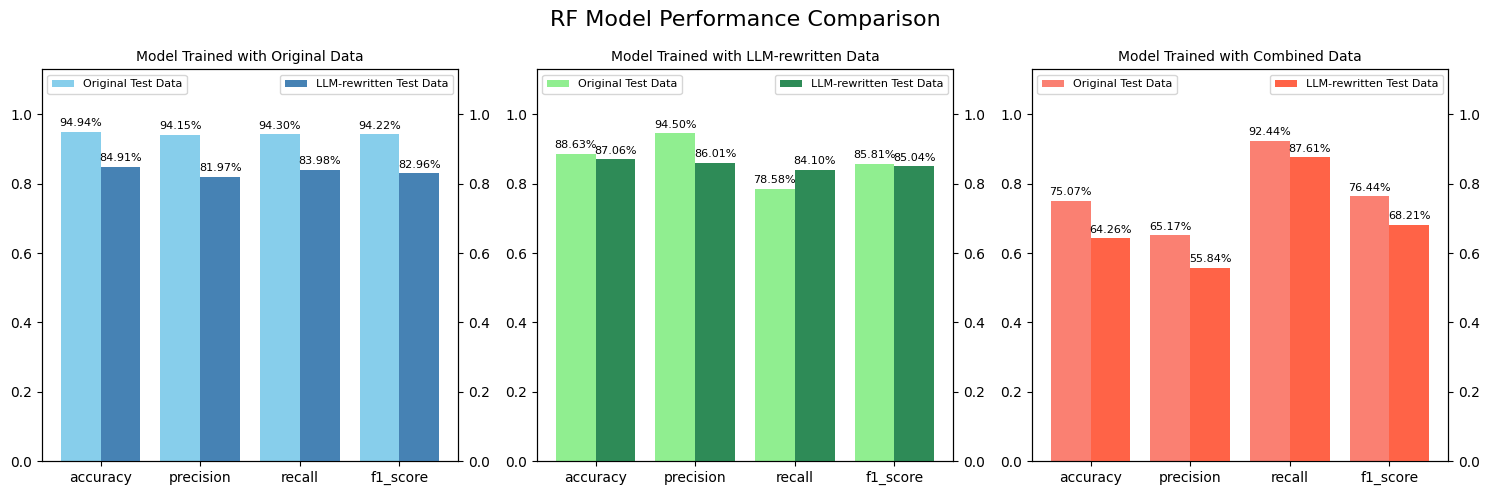

In [19]:
plot_results(model, perf_original_model_val_data, perf_original_model_val_data_rewritten, 
             perf_combined_model_val_data, perf_combined_model_val_data_rewritten, 
             perf_rewritten_model_val_data, perf_rewritten_model_val_data_rewritten)